<a href="https://colab.research.google.com/github/starkjiang/TrAC-Generative-Models/blob/main/variational_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy Example Using Maximum Likelihood Estimation and Variational Inference

In this tutorial, we generate a simple synthetic dataset and use two methods for demo, including Maximum Likelihood Estimation (MLE) and Variational Inference (VI).

The dataset generation follows a simple linear model:

$y = 2x+0.5\epsilon$, where $x\sim \mathcal{N}(0,1)$ and $\epsilon\sim\mathcal{N}(0,1)$

# MLE

We use a simple one-layer linear neural network with MLE, where we assume a Gaussian likelihood.

$y\sim\mathcal{N}(g_\theta(x), \sigma^2)$

$\hat{\theta}_{MLE} = \text{argmax}_\theta\prod_{i}^nP(y_i|\theta)$

# Variational Inference

In VI, we accept the fact that we may not get the true posterior $p(y|x)\propto p(x|y)p(y)$, but we try to approximate this distribution with another parameterized distribution, say $Q_\theta(y)$. If we choose a factorized Gaussian distribution, $Q_\theta(y)$ would become $Q_\theta(\mu, \text{diag}(\sigma^2))$. **Note that we are now working with an 1D case and that this factorization doesn't mean much right now.** We want the distribution to be conditioned on $x$. Therefore, we define a function $g_\theta: x\mapsto \mu, \sigma$. The function $g_\theta$ will be a neural network to predict the variational parameters. The model can thus be described as:

$p(y)\sim\mathcal{N}(0,1)$ (Unit Gaussian Prior)

$Q(y|x) = \mathcal{N}(g_\theta(x)_
\mu,\text{diag}(g_\theta(x)_{\sigma^2}))$

# Optimization Problem

Note: Above we have defined the posterior and the variational distribution in the variable $y|x$. We will generalize to a more often used notation, which is defined by a latent variable $Z$.

Variational Inference is done by maximizing the Evidence Lower Bound (ELBO), which can be written as follows:

$\text{argmax}_Z = \mathbb{E}_{Z\sim Q}[\text{log}p(D|Z)] - \mathcal{D}_{KL}(Q(Z)||p(Z))$,

where $p(Z)$ is the prior.

The first term on the right hand side in the last equality is called likelihood, but in VI, it has a more generic name, "recosntruction loss". While the second term is called KL-divergence between the prior and variational distribution.

Next, we are going to rewrite the loss function to make it more adaptive to optimization.

We substitute the definition of the KL-divergence into the loss function such that

$\mathbb{E}_{Z\sim Q}[\text{log}p(D|Z)] + \int Q(z)\text{log}\frac{p(Z)}{Q(Z)}dZ$

The integral term can be rewritten as an expectation in the following:

$\mathbb{E}_{Z\sim Q}[\text{log}p(D|Z)] + \mathbb{E}_{Z\sim Q(Z)}\text{log}[\frac{p(Z)}{Q(Z)}] = \mathbb{E}_{Z\sim Q}[\text{log}p(D|Z)] + \mathbb{E}_{Z\sim Q(Z)}[\text{log}p(Z)-\text{log}Q(Z)]$

Deriving those expectations can be some tedious mathematics, or maybe not even possible. Luckily we can get estimates of the mean by taking samples from $Q(Z)$
and average over those results.

# Reparameterization Trick

However, **sampling from $Q(Z)$ will make the whole pipeline non-deterministic such that the differentiability cannot be guaranteed in the backpropagation. We avoid this problem by reparameterizing the samples from the distribution.**

Instead of sampling directly from the variational distribution

$z\sim Q(\mu, \sigma^2)$

We sample from a unit gaussian and recreate samples from the variational distribution. Now the stochasticity of $\epsilon$ is external and will not prevent the flow of gradients.

$z=\mu + \sigma\odot \epsilon$, where $\epsilon\sim\mathcal{N}(0,1)$.

Since the prior and the variational distribution are all Gaussian, the KL divergence can be computed as

$\mathcal{D}_{KL}(Q(Z)|P(Z)) = \text{log}\frac{\sigma_2}{\sigma_1}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2} - \frac{1}{2}$

If $p(Z)\sim\mathcal{N}(0,1)$, then the last equation becomes

$\mathcal{D}_{KL}(Q(Z)|\mathcal{N}(0,1)) = \text{log}\frac{1}{\sigma_1}+\frac{\sigma_1^2+(\mu_1-0)^2}{2} - \frac{1}{2} = \frac{\mu_1^2+\sigma_1^2}{2}-\text{log}\sigma_1-\frac{1}{2}$.

In implementation, we typically regard the entire $\text{log}\sigma_1$ as the learnable parameter.


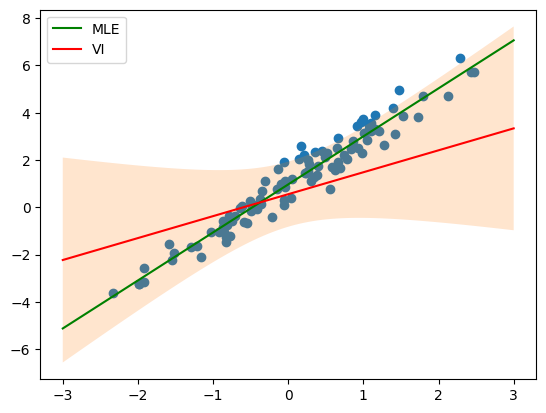

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Define a simple linear model.
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)


class BayesianLinearRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianLinearRegression, self).__init__()

        self.in_features = in_features
        self.out_features = out_features

        # Define variational distributions for weights and bias
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_log_sigma = nn.Parameter(
            torch.zeros(out_features, in_features)
        )
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_log_sigma = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        # Reparameterization trick for sampling weights and bias
        weight_epsilon = torch.randn_like(self.weight_mu)
        bias_epsilon = torch.randn_like(self.bias_mu)

        weight = self.weight_mu + self.weight_log_sigma.exp() * weight_epsilon
        bias = self.bias_mu + self.bias_log_sigma.exp() * bias_epsilon

        return x @ weight.t() + bias

    def elbo(self, x, y):
        # TODO: Compute the negative ELBO loss
        ########################## Your code is here!###########################
        # 1. Calculate the prediction based on the forward function.
        # 2. Calculate the log_likelihood for the ground truth and predictions.
        # 3. Calculate the explicit KL divergence based on the formula in the
        # text block.
        # Note: the prior distribution follows standard Normal distribution
        # N(0,1).
        # 4. Return the elbo.
        y_pred = self.forward(x)
        log_likelihood = -0.5 * torch.sum((y_pred - y) ** 2)
        kl_divergence = 0.5 * torch.sum(
            self.weight_log_sigma.exp()**2 + self.weight_mu ** 2 - 1 - 2 * self.weight_log_sigma
        ) + 0.5 * torch.sum(
            self.bias_log_sigma.exp()**2 + self.bias_mu ** 2 - 1 - 2 * self.bias_log_sigma)
        ########################################################################
        return -log_likelihood + kl_divergence

# Generate some synthetic data
x = torch.randn(100, 1)
y = 2 * x + 1 + 0.5 * torch.randn(100, 1)

# Maximum Likelihood Estimation (MLE)
model_mle = LinearModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_mle.parameters(), lr=0.01)

# Train the MLE model
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model_mle(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

# Create model and optimizer
model_vi = BayesianLinearRegression(1, 1)
optimizer = optim.Adam(model_vi.parameters())

# Train the model
for epoch in range(1000):
    optimizer.zero_grad()
    loss = model_vi.elbo(x, y)
    loss.backward()
    optimizer.step()

# Testing and plotting
x_test = torch.linspace(-3, 3, 100).unsqueeze(1)
y_pred_list = []
for _ in range(100):
    y_pred = model_vi(x_test)
    y_pred_list.append(y_pred.detach())

y_pred_mean = torch.mean(torch.stack(y_pred_list), dim=0)
y_pred_std = torch.std(torch.stack(y_pred_list), dim=0)

plt.scatter(x, y)
plt.plot(
    x_test.numpy(),
    model_mle(x_test).detach().numpy(),
    color='g',
    label='MLE'
)
plt.plot(x_test, y_pred_mean, color='red', label="VI")
plt.fill_between(
    x_test.squeeze(),
    y_pred_mean.squeeze() - 2 * y_pred_std.squeeze(),
    y_pred_mean.squeeze() + 2 * y_pred_std.squeeze(),
    alpha=0.2
)
plt.legend()